In [37]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import string
import io
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/agustin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
def return_sia_compound_values(text):
    return sia.polarity_scores(text)['compound']

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/agustin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [39]:
def remove_stopword(text):
    new_text = []
    for e in text:
        if e not in stopwords and e.isalpha():
            new_text.append(e)
    text = new_text
    return " ".join(new_text)

def stemm(text):
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

def contains_punctuation(text):
    punctuation = set(string.punctuation)
    for character in text:
        if character in punctuation:
            return True
    return False

def amount_of_punctuation(text):
    punctuation = set(string.punctuation)
    amount = 0
    for character in text:
        if character in punctuation: amount += 1
    return amount

In [40]:
tweets = pd.read_csv("train.csv", usecols=['id','text', 'target'])
test = pd.read_csv("test.csv")

In [41]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7434 non-null   int64 
 1   text    7434 non-null   object
 2   target  7434 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 232.3+ KB


In [42]:
tweets_metrics = tweets[['id','text','target']]
tweets_metrics['text_without_stopwords'] = tweets_metrics['text'].str.split()
tweets_metrics['text_without_stopwords'] = tweets_metrics['text_without_stopwords'].apply(remove_stopword)

tweets_metrics['length'] = tweets_metrics['text'].apply(lambda x: len(x))
tweets_metrics['avg_word_length'] = tweets_metrics['text'].str.split().apply(lambda x: [len(y) for y in x]).transform(lambda x: np.mean(x))
tweets_metrics['amount_of_words'] = tweets_metrics['text'].str.split().transform(lambda x: len(x))
unique_words_by_tweet = tweets_metrics['text'].transform(lambda x: x.split()).transform(lambda x: pd.Series(x).unique()).transform(lambda x: len(x))
tweets_metrics['amount_of_unique_words'] = unique_words_by_tweet
tweets_metrics['sentiment'] = tweets_metrics['text'].apply(lambda x: return_sia_compound_values(x))
tweets_metrics['stopwords_count'] = tweets_metrics['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in stopwords]))
tweets_metrics['punctuation_count'] = tweets_metrics['text'].apply(lambda x: amount_of_punctuation(x))
mentions = tweets_metrics['text'].str.findall(r'@.\S*?(?=\s|[:]|$)').to_frame()
tweets_metrics['mentions_count'] = mentions['text'].apply(lambda x: len(x))
hashtags = tweets_metrics['text'].str.findall(r'#[^?\s].*?(?=\s|$)')
tweets_metrics['hashtags_count'] = hashtags.apply(lambda x: len(x))
tweets_metrics['longest_word_length_without_stopwords'] = tweets_metrics['text_without_stopwords'].apply(lambda x: ([len(word) for word in str(x).lower().split() if not word.startswith('http')])).apply(lambda x: max(x) if len(x) > 0 else 0)

tweets_metrics.head()

TypeError: 'numpy.float64' object is not callable

# Split de features

In [ ]:
data_cols = ['length','avg_word_length','amount_of_words','amount_of_unique_words','sentiment','stopwords_count','punctuation_count','mentions_count','hashtags_count','longest_word_length_without_stopwords']
basic_data_cols = ['length','avg_word_length','amount_of_words','amount_of_unique_words','sentiment','stopwords_count','punctuation_count','longest_word_length_without_stopwords']
x_train, x_test, y_train, y_test = \
train_test_split(tweets_metrics[data_cols], tweets_metrics['target'], test_size = 0.05, random_state = 123)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
vectorizer = TfidfVectorizer()
tfidf_lgbm = vectorizer.fit_transform(tweets_metrics.loc[:, 'text'])
array = tfidf_lgbm.todense()

In [ ]:
df = pd.DataFrame(array)
df['output'] = tweets['target']
basic_features = tweets_metrics[['length','avg_word_length','amount_of_words','amount_of_unique_words','sentiment','stopwords_count','punctuation_count','mentions_count','hashtags_count','longest_word_length_without_stopwords']]
tfidf_features = df.merge(basic_features, left_index = True, right_index = True)
tfidf_features

In [ ]:
features = tfidf_features.columns.drop('output')
x = tfidf_features.loc[:, features].values
y = tfidf_features.loc[:, 'output'].values

from sklearn.model_selection import train_test_split
x_tfidf_train, x_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(x, y, test_size = 0.25, random_state = 123)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_tfidf_train = sc.fit_transform(x_tfidf_train)
x_tfidf_test = sc.transform(x_tfidf_test)
print(x_tfidf_train.shape, x_tfidf_test.shape)

### Split de TF-IDF

In [ ]:
x_text_train, x_text_test, y_text_train, y_text_test = \
train_test_split(tweets_metrics['text'], tweets_metrics['target'], test_size = 0.25, random_state = 123)

In [ ]:
tfid_vectorizer = TfidfVectorizer()
train_vectors = tfid_vectorizer.fit_transform(x_text_train)
test_vectors = tfid_vectorizer.transform(x_text_test)
print(train_vectors.shape, test_vectors.shape)

### Split count vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
count_train = count_vectorizer.fit_transform(x_text_train)
count_test = count_vectorizer.transform(x_text_test)
print(count_train.shape, count_test.shape, y_text_train.shape,y_text_test.shape )

### Split de Hash vectorizer

In [43]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vectorizer = HashingVectorizer()
hash_train = hash_vectorizer.fit_transform(x_text_train)
hash_test = hash_vectorizer.fit_transform(x_text_test)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
hash_train = sc.fit_transform(hash_train)
hash_test = sc.transform(hash_test)

### Para submits

In [44]:
test = pd.read_csv("test.csv")

### TF-IDF

In [45]:
train_vectors_full = tfid_vectorizer.fit_transform(tweets_metrics['text'])
test_vectors_full = tfid_vectorizer.transform(test['text'])
y_train_full = tweets_metrics['target']
print(train_vectors_full.shape, test_vectors_full.shape )

(7434, 21529) (3263, 21529)


### KNN : baseline
 *En principio usando un bootstrap del set de entrenamiento para medir accuracy. Se utilizo un 25% del set para entrenar y el 75% restante para la predicción. Se utilizó la representación TF-IDF para el entrenamiento ya que KNN funciona con valores numericos.*
 
Methods

* fit(self, X, y) Fit the model using X as training data and y as target values

* get_params(self[, deep]) Get parameters for this estimator.

* kneighbors(self[, X, n_neighbors, …]) Finds the K-neighbors of a point.

* kneighbors_graph(self[, X, n_neighbors, mode]) Computes the (weighted) graph of k-Neighbors for points in X

* predict(self, X) Predict the class labels for the provided data.

* predict_proba(self, X) Return probability estimates for the test data X.

* score(self, X, y[, sample_weight]) Return the mean accuracy on the given test data and labels.

* set_params(self, \*\*params) Set the parameters of this estimator.

### KNN con basic features

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train, y_train)
max = knn.score(x_test, y_test)
actual = max
optimo = 1

for i in range(2, 100):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train, y_train)
    actual = knn.score(x_test, y_test)
    if max < actual:
        optimo = i 
        max = actual

print(optimo, max) #0.6853146853146853 con 20 con basic features 22 con features

50 0.6933835395373857


In [19]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=43)
all_accuracies = cross_val_score(estimator=knn, X=x_train, y=y_train, cv=40)
print(all_accuracies.mean())

0.6844373072970196


### KNN con TF-IDF

In [52]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_vectors, y_text_train)
max = knn.score(test_vectors, y_text_test)
actual = max
optimo = 1


for i in range(1, 100, 1):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(train_vectors, y_text_train)
    actual = knn.score(test_vectors, y_text_test)
    if max < actual:
        optimo = i 
        max = actual

ensemble = VotingClassifier(estimators=models, voting='hard')  
ensemble.fit(train_vectors_full, y_train_full)
predicted = ensemble.predict(test_vectors_full)
test['target'] = predicted
submit_kaggle = test.loc[:, ['id', 'target']]
submit_kaggle.to_csv("prueba_ensambleknn.csv", index=False)
print(optimo, max) #0.7961269499731038 con 49

1 0.7912856374394835


In [64]:
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier


models = []
knn = KNeighborsClassifier(n_neighbors=1)
models.append(('knn0',knn))


for i in range(1, 100, 1):
    knn = KNeighborsClassifier(n_neighbors = i)
    models.append(("knn"+str(i),knn))

xg_reg = xgb.XGBClassifier(objective ='reg:logistic', 
                colsample_bytree = 0.5, colsample_bylevel = 0.85, learning_rate = 0.05,
                max_depth = 17, min_child_weight = 3, alpha = 0.6, gamma =  0.9, n_estimators = 210)
models.append(('xgb0', xg_reg))
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', 
                colsample_bytree = 0.45, colsample_bylevel = 0.4, learning_rate = 0.05,
                max_depth = 25, min_child_weight = 1.1, alpha = 0.5, gamma =  0.4, n_estimators = 210)
models.append(('xgb1', xg_reg))
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', 
                colsample_bytree = 0.65, colsample_bylevel = 0.6, learning_rate = 0.05,
                max_depth = 20, min_child_weight = 2, alpha = 0.7, gamma =  0.8, n_estimators = 210)
models.append(('xgb2', xg_reg))
xg_reg = xgb.XGBClassifier(objective ='reg:logistic', 
                colsample_bytree = 0.35, colsample_bylevel = 0.3, learning_rate = 0.1,
                max_depth = 35, min_child_weight = 1.5, alpha = 0.9, gamma =  0.4, n_estimators = 240)

models.append(('xgb3', xg_reg))
ensemble = VotingClassifier(estimators=models, voting='soft')  
ensemble.fit(train_vectors_full, y_train_full)
predicted = ensemble.predict(test_vectors_full)
test['target'] = predicted
submit_kaggle = test.loc[:, ['id', 'target']]
submit_kaggle.to_csv("xgb_knn.csv", index=False)

### KNN con count vectorizer

In [44]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(count_train, y_text_train)
max = knn.score(count_test, y_text_test)
actual = max
optimo = 1

for i in range(2, 100):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(count_train, y_text_train)
    actual = knn.score(count_test, y_text_test)
    if max < actual:
        optimo = i 
        max = actual

print(optimo, max) #0.6778749159381304 con 1 (basura)

KeyboardInterrupt: 

### Submit

In [23]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(train_vectors_full, y_train_full)
predicted = knn.predict(test_vectors_full)

In [24]:
test['target'] = predicted
submit_kaggle = test.loc[:, ['id', 'target']]
submit_kaggle.to_csv("knn_tfidf.csv", index=False)

### XGBoost

### Busqueda de parametros con feature engineering

In [25]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#acc = 0.7305002689618074(objective ='binary:logistic', colsample_bytree = 0.6, learning_rate = 0.01, max_depth = 35,alpha = 0.5, n_estimators = 140) 
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', 
                colsample_bytree = 0.6, learning_rate = 0.005,
                max_depth = 35,alpha = 0.5, n_estimators = 140) 
xg_reg.fit(x_train,y_train) 
y_pred = xg_reg.predict(x_test)

for i in range (0, len(y_pred)):
    if y_pred[i] >= 0.5:       
        y_pred[i] = 1 
    else:  
        y_pred[i]=0
        
accuracy = accuracy_score(y_pred,y_test)
print(accuracy)

0.7197417966648736


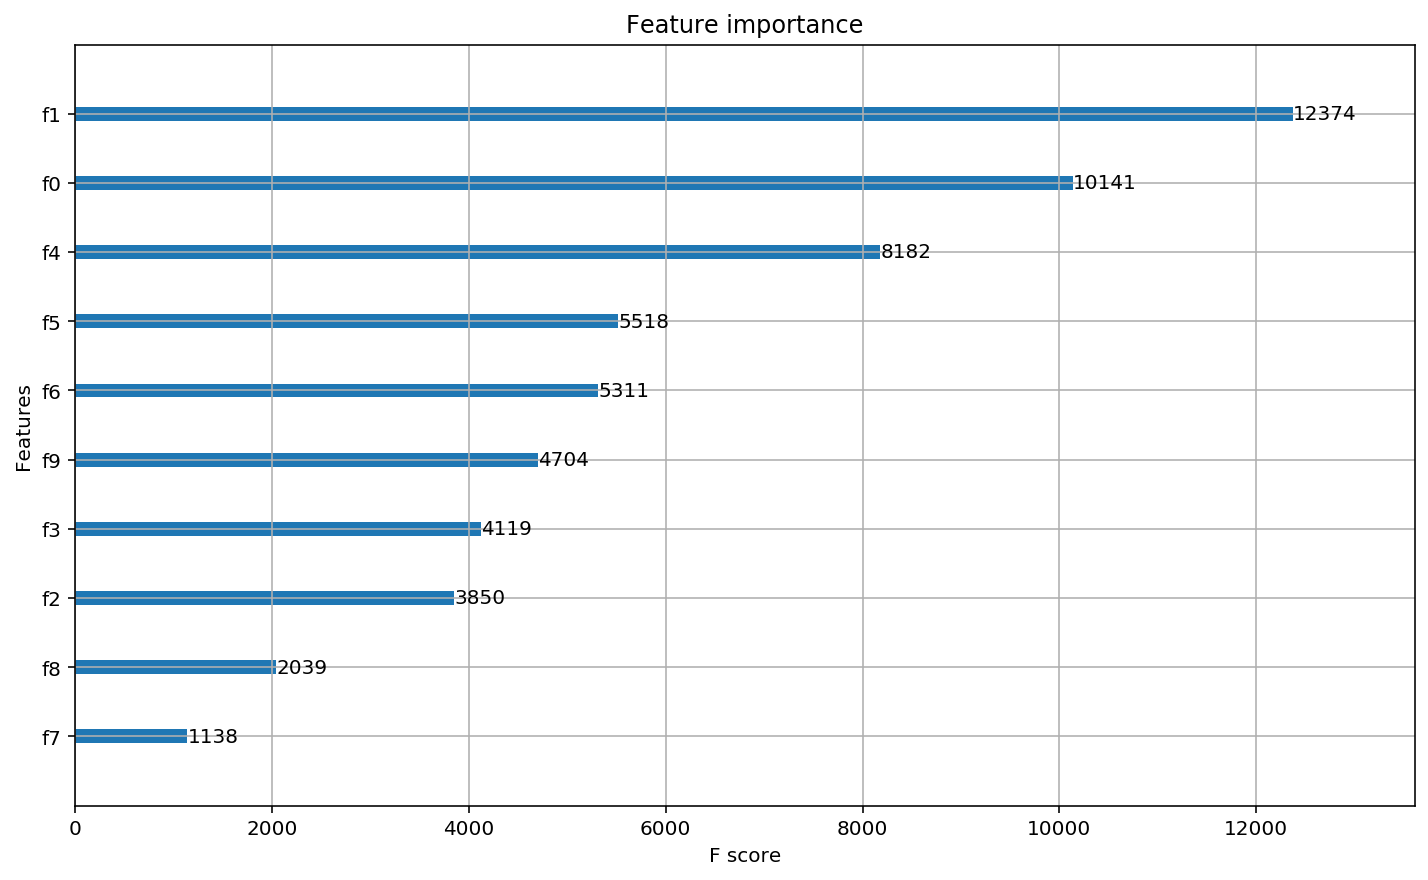

In [26]:
kfold = KFold(n_splits=10)
results = cross_val_score(xg_reg, x_train, y_train, cv=kfold)
results

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)

### XGBoost con TF-IDF

### Busqueda de parametros

In [27]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = dict(learning_rate = np.arange(0.001,0.1,0.005),
                              n_estimators = np.arange(15,300,15),
                              scale_pos_weight = np.arange(2,6,1),
                              max_depth = np.arange(15,40,2),min_child_weight= np.arange(1,10,1),
                              gamma = np.arange(0,1,0.1), alpha= np.arange(0.1,1,0.1),
                              subsample = np.arange(0,1,0.1), colsample_bytree = np.arange(0.5,0.8,0.05),
                              colsample_bylevel = np.arange(0.6,0.91,0.05))
xgb_model = xgb.XGBClassifier()

grid = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                              cv=4, verbose=2, n_iter=20, n_jobs=1)
grid_result = grid.fit(train_vectors,y_text_train)
params_xgb_tfidf = grid_result.best_params_
print("Best parameters: ", params_xgb_tfidf)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] subsample=0.1, scale_pos_weight=3, n_estimators=150, min_child_weight=3, max_depth=31, learning_rate=0.066, gamma=0.30000000000000004, colsample_bytree=0.55, colsample_bylevel=0.7500000000000001, alpha=0.2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.1, scale_pos_weight=3, n_estimators=150, min_child_weight=3, max_depth=31, learning_rate=0.066, gamma=0.30000000000000004, colsample_bytree=0.55, colsample_bylevel=0.7500000000000001, alpha=0.2, total=   4.4s
[CV] subsample=0.1, scale_pos_weight=3, n_estimators=150, min_child_weight=3, max_depth=31, learning_rate=0.066, gamma=0.30000000000000004, colsample_bytree=0.55, colsample_bylevel=0.7500000000000001, alpha=0.2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV]  subsample=0.1, scale_pos_weight=3, n_estimators=150, min_child_weight=3, max_depth=31, learning_rate=0.066, gamma=0.30000000000000004, colsample_bytree=0.55, colsample_bylevel=0.7500000000000001, alpha=0.2, total=   4.4s
[CV] subsample=0.1, scale_pos_weight=3, n_estimators=150, min_child_weight=3, max_depth=31, learning_rate=0.066, gamma=0.30000000000000004, colsample_bytree=0.55, colsample_bylevel=0.7500000000000001, alpha=0.2 
[CV]  subsample=0.1, scale_pos_weight=3, n_estimators=150, min_child_weight=3, max_depth=31, learning_rate=0.066, gamma=0.30000000000000004, colsample_bytree=0.55, colsample_bylevel=0.7500000000000001, alpha=0.2, total=   3.3s
[CV] subsample=0.1, scale_pos_weight=3, n_estimators=150, min_child_weight=3, max_depth=31, learning_rate=0.066, gamma=0.30000000000000004, colsample_bytree=0.55, colsample_bylevel=0.7500000000000001, alpha=0.2 
[CV]  subsample=0.1, scale_pos_weight=3, n_estimators=150, min_child_weight=3, max_depth=31, learning_rate=0.066, gamma=0.

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  6.4min finished


Best parameters:  {'subsample': 0.9, 'scale_pos_weight': 3, 'n_estimators': 210, 'min_child_weight': 3, 'max_depth': 17, 'learning_rate': 0.091, 'gamma': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8500000000000002, 'alpha': 0.6}


In [28]:
xg_reg = xgb.XGBClassifier(**params_xgb_tfidf)
xg_reg.fit(train_vectors,y_text_train)
preds = xg_reg.predict(test_vectors)
for i in range (0, len(preds)):
    if preds[i] >= 0.5:       
        preds[i] = 1 
    else:  
        preds[i] = 0

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,y_text_test)
print(accuracy)

0.7321140398063475


### Submit

In [29]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:logistic', 
                colsample_bytree = 0.45, colsample_bylevel = 0.4, learning_rate = 0.05,
                max_depth = 25, min_child_weight = 1.1, alpha = 0.5, gamma =  0.4, n_estimators = 210)
xg_reg.fit(train_vectors_full, y_train_full)
predicted = xg_reg.predict(test_vectors_full)
for i in range (0, len(predicted)):
    if predicted[i] >= 0.5:       
        predicted[i] = int(1.0)
    else:  
        predicted[i] = int(0)
test['target'] = predicted
test['target'] = test['target'].astype(int)
submit_kaggle = test.loc[:, ['id', 'target']]
submit_kaggle.to_csv("submit_prueba_20.csv", index=False)

In [30]:
from sklearn.model_selection import cross_val_score

xg_reg = xgb.XGBRegressor(objective ='reg:logistic', 
                colsample_bytree = 0.45, colsample_bylevel = 0.4, learning_rate = 0.05,
                max_depth = 25, min_child_weight = 1.1, alpha = 0.5, gamma =  0.4, n_estimators = 210)
all_accuracies = cross_val_score(estimator=xg_reg, X=train_vectors, y=y_text_train, cv=10)
print(all_accuracies.mean())

0.3486382501805172


### XGBoost con count-vectorizer

### Busqueda de parametros

In [31]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = dict(learning_rate = np.arange(0.01,0.5,0.02),
                              n_estimators = np.arange(15,300,15),
                              scale_pos_weight = np.arange(2,6,1),
                              max_depth = np.arange(15,40,2),min_child_weight= np.arange(1,10,1),
                              gamma = np.arange(0,0.5,0.1), alpha= np.arange(0.1,1,0.1),
                              subsample = np.arange(0.6,1,0.1), colsample_bytree = np.arange(0.5,0.8,0.05),
                              colsample_bylevel = np.arange(0.6,0.91,0.05))
classifier = xgb.XGBClassifier()

grid = RandomizedSearchCV(estimator=classifier, param_distributions=param_grid,
                              cv=4, verbose=2, n_iter=20, n_jobs=1)
grid_result = grid.fit(count_train,y_text_train)
params_xgb_count = grid_result.best_params_
print("Best parameters: ", params_xgb_count)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV] subsample=0.7999999999999999, scale_pos_weight=5, n_estimators=240, min_child_weight=1, max_depth=39, learning_rate=0.10999999999999997, gamma=0.4, colsample_bytree=0.6500000000000001, colsample_bylevel=0.8500000000000002, alpha=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.7999999999999999, scale_pos_weight=5, n_estimators=240, min_child_weight=1, max_depth=39, learning_rate=0.10999999999999997, gamma=0.4, colsample_bytree=0.6500000000000001, colsample_bylevel=0.8500000000000002, alpha=0.8, total=  44.1s
[CV] subsample=0.7999999999999999, scale_pos_weight=5, n_estimators=240, min_child_weight=1, max_depth=39, learning_rate=0.10999999999999997, gamma=0.4, colsample_bytree=0.6500000000000001, colsample_bylevel=0.8500000000000002, alpha=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   44.1s remaining:    0.0s


[CV]  subsample=0.7999999999999999, scale_pos_weight=5, n_estimators=240, min_child_weight=1, max_depth=39, learning_rate=0.10999999999999997, gamma=0.4, colsample_bytree=0.6500000000000001, colsample_bylevel=0.8500000000000002, alpha=0.8, total=  43.1s
[CV] subsample=0.7999999999999999, scale_pos_weight=5, n_estimators=240, min_child_weight=1, max_depth=39, learning_rate=0.10999999999999997, gamma=0.4, colsample_bytree=0.6500000000000001, colsample_bylevel=0.8500000000000002, alpha=0.8 
[CV]  subsample=0.7999999999999999, scale_pos_weight=5, n_estimators=240, min_child_weight=1, max_depth=39, learning_rate=0.10999999999999997, gamma=0.4, colsample_bytree=0.6500000000000001, colsample_bylevel=0.8500000000000002, alpha=0.8, total=  42.3s
[CV] subsample=0.7999999999999999, scale_pos_weight=5, n_estimators=240, min_child_weight=1, max_depth=39, learning_rate=0.10999999999999997, gamma=0.4, colsample_bytree=0.6500000000000001, colsample_bylevel=0.8500000000000002, alpha=0.8 
[CV]  subsampl

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 16.0min finished


Best parameters:  {'subsample': 0.6, 'scale_pos_weight': 2, 'n_estimators': 180, 'min_child_weight': 1, 'max_depth': 25, 'learning_rate': 0.36999999999999994, 'gamma': 0.2, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.8000000000000002, 'alpha': 0.30000000000000004}


In [32]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

xg_reg = xgb.XGBRegressor(**params_xgb_count)
xg_reg.fit(count_train,y_train) 
y_pred = xg_reg.predict(count_test)

for i in range (0, len(y_pred)):
    if y_pred[i] >= 0.5:       
        y_pred[i] = 1 
    else:  
        y_pred[i]=0
        
accuracy = accuracy_score(y_pred,y_test)
print(accuracy)

0.7019903173749328


In [33]:
np.arange(0.6,0.91,0.05)

array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ])

In [34]:
[0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ]

[0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

### XGBoost con Hash vectorizer

In [36]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:logistic', 
                colsample_bytree = 0.45, colsample_bylevel = 0.4, learning_rate = 0.05,
                max_depth = 25, min_child_weight = 1.1, alpha = 0.5, gamma =  0.4, n_estimators = 210)
xg_reg.fit(hash_train, y_train)
y_pred = xg_reg.predict(hash_test)

for i in range (0, len(y_pred)):
    if y_pred[i] >= 0.5:       
        y_pred[i] = 1 
    else:  
        y_pred[i]=0
        
accuracy = accuracy_score(y_pred,y_test)
print(accuracy)

0.7912856374394835
